In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])])

# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [3]:
# hidden_layers = [512, 256, 128, 64]
# layer_sizes = zip(hidden_layers[1:], hidden_layers[:-1])
#
# for each in layer_sizes:
#     print(each)

In [4]:
class Network(nn.Module):

    def __init__(self,input_size,output_size,hidden_layers,drop_p=0.5):

        super().__init__()

        self.hidden_layers = nn.ModuleList([nn.Linear(input_size,hidden_layers[0])])

        layer_sizes = zip(hidden_layers[:-1],hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1,h2) for  h1,h2 in layer_sizes])

        self.output = nn.Linear(hidden_layers[-1],output_size)

        self.dropout = nn.Dropout(p=drop_p)

    def forward(self,x):

        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)

        x = self.output(x)

        return  F.log_softmax(x,dim=1)


In [5]:
model = Network(784,10,[516,256], drop_p = 0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
test_loss = 0
images, labels = next(iter(testloader))

images.resize_(images.shape[0],784)

output = model.forward(images)
test_loss += criterion(output,labels).item()

ps = torch.exp(output)
ps.shape

torch.Size([64, 10])

In [7]:
ps.max(dim=1)

torch.return_types.max(
values=tensor([0.1239, 0.1126, 0.1329, 0.1220, 0.1485, 0.1229, 0.1145, 0.1200, 0.1120,
        0.1147, 0.1195, 0.1276, 0.1143, 0.1126, 0.1180, 0.1162, 0.1226, 0.1276,
        0.1237, 0.1204, 0.1201, 0.1162, 0.1159, 0.1174, 0.1167, 0.1263, 0.1228,
        0.1299, 0.1420, 0.1167, 0.1126, 0.1243, 0.1257, 0.1154, 0.1302, 0.1199,
        0.1187, 0.1268, 0.1201, 0.1215, 0.1352, 0.1416, 0.1218, 0.1303, 0.1271,
        0.1226, 0.1260, 0.1241, 0.1179, 0.1111, 0.1262, 0.1244, 0.1156, 0.1172,
        0.1201, 0.1245, 0.1285, 0.1412, 0.1175, 0.1206, 0.1109, 0.1288, 0.1105,
        0.1330], grad_fn=<MaxBackward0>),
indices=tensor([6, 3, 2, 1, 2, 6, 6, 9, 0, 6, 3, 7, 7, 6, 1, 0, 3, 0, 6, 6, 1, 3, 4, 7,
        0, 6, 4, 6, 7, 2, 4, 3, 6, 7, 3, 8, 1, 1, 9, 0, 2, 6, 9, 3, 9, 8, 6, 9,
        6, 0, 6, 2, 7, 3, 9, 8, 6, 3, 2, 0, 6, 1, 6, 2]))

In [8]:
equalit = (labels.data == ps.max(dim=1)[1])
equalit

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False])

In [9]:
accurac = equalit.type(torch.FloatTensor).mean()
accurac

tensor(0.0625)

In [10]:
def validation(model,testloader,criterion):

    test_loss = 0
    accuracy = 0

    for images, labels in testloader:

        images.resize_(images.shape[0],784)

        output = model.forward(images)
        test_loss += criterion(output,labels).item()

        ps = torch.exp(output)

        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

In [11]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40

for e in range(epochs):
    for images,labels in trainloader:
        steps += 1

        images.resize_(images.size()[0],784)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output,labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:

            model.eval() # we do not want drop out on while on validation

            with torch.no_grad():
                test_loss,accuracy = validation(model,testloader,criterion)


            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

            running_loss = 0

            model.train() # turn drop out back on

Epoch: 1/2..  Training Loss: 1.317..  Test Loss: 0.835..  Test Accuracy: 0.674
Epoch: 1/2..  Training Loss: 0.817..  Test Loss: 0.665..  Test Accuracy: 0.743
Epoch: 1/2..  Training Loss: 0.702..  Test Loss: 0.604..  Test Accuracy: 0.776
Epoch: 1/2..  Training Loss: 0.693..  Test Loss: 0.582..  Test Accuracy: 0.779
Epoch: 1/2..  Training Loss: 0.626..  Test Loss: 0.565..  Test Accuracy: 0.788
Epoch: 1/2..  Training Loss: 0.643..  Test Loss: 0.555..  Test Accuracy: 0.793
Epoch: 1/2..  Training Loss: 0.623..  Test Loss: 0.543..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.612..  Test Loss: 0.508..  Test Accuracy: 0.813
Epoch: 1/2..  Training Loss: 0.577..  Test Loss: 0.529..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.592..  Test Loss: 0.527..  Test Accuracy: 0.803
Epoch: 1/2..  Training Loss: 0.545..  Test Loss: 0.501..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.566..  Test Loss: 0.516..  Test Accuracy: 0.810
Epoch: 1/2..  Training Loss: 0.560..  Test Loss: 0.5

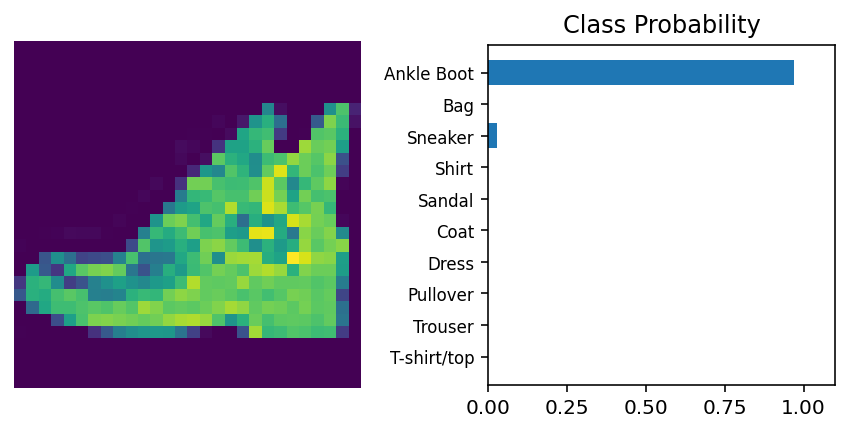

In [12]:
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')